# King County House Sales Regression Analysis

**Student name:** Rebecca Chu

## Overview

This project utilises an iterative approach to building a multiple linear regression model.

## Business Problem

King County Real Estate Agency is looking to improve their accuracy when determining a recommended listing price for their clients' properties so that sellers are able to sell their houses within a reasonable timeframe but still at a maximum profit. The agency would like to know which features of a house are the best predictors for price and whether any actionable insights can be recommended to the homeowner to increase the price of their property. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statistics as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

from geopy.distance import geodesic as GD

from itertools import combinations

## Data Understanding
### King County House Sales

This analysis explores the King County House Sales data, which was provided for this project. The dataset provided property information for 21,597 houses that were sold between May 2014 and May 2015. The target variable is house sale prices.

For the description of the column names please refer to `column_names.md` in the `data` folder.

In [2]:
kc = pd.read_csv('./data/kc_house_data.csv')
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Data Preparation
### 1. Data Cleaning

#### 1.1. Converting Datatypes

In [3]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

We can see that the majority of columns are numerical datatypes, with the exception of `date` and `sqft_basement`, which are object datatypes. As I am interested in the relationship between the target variable and the time of year the house was sold, I converted `date` into a datetime datatype.

In [4]:
# converting date to datetime datatype
kc.date = pd.to_datetime(kc.date)

# descriptive statistics for date Series
kc.date.describe()

count                            21597
mean     2014-10-29 04:20:38.171968512
min                2014-05-02 00:00:00
25%                2014-07-22 00:00:00
50%                2014-10-16 00:00:00
75%                2015-02-17 00:00:00
max                2015-05-27 00:00:00
Name: date, dtype: object

In [5]:
# adding a new column for month sold
kc['month_sold'] = kc.date.dt.month

In [6]:
# adding a new column for age of house at the time of sell
kc['age'] = kc.date.dt.year - kc.yr_built

I also wanted to take a look at the relationship between location and price. I generated a map of King County by plotting each house according their coordinates. 

I marked where Seattle and Bellevue were, the largest and second largest cities of the county by population total respectively. The `o` marks Seattle, `x` marks Bellevue.

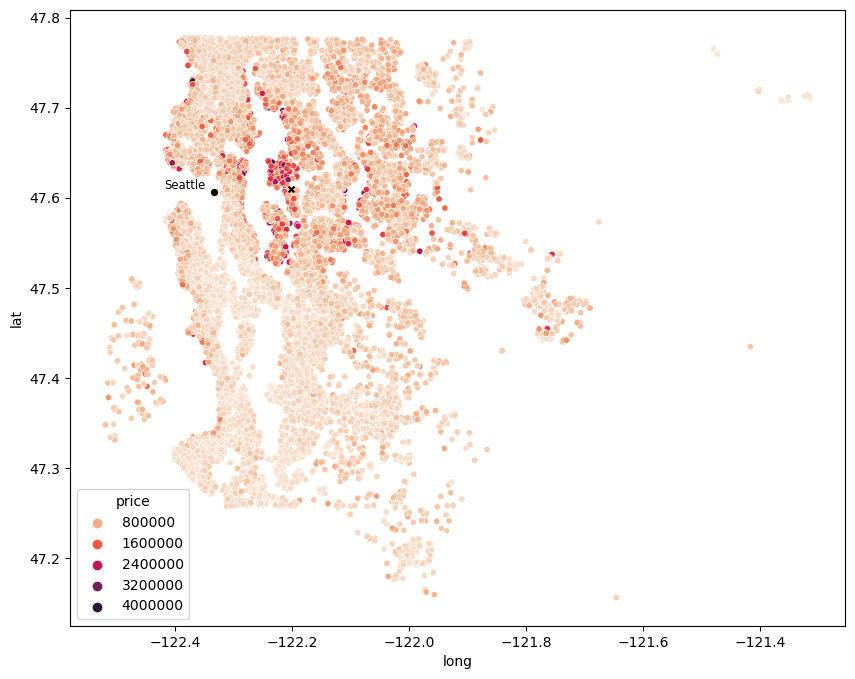

In [68]:
# plotting houses according to latitude and longitude
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=kc.long, y=kc.lat, hue=kc.price, s=20, palette='rocket_r')

plt.scatter(-122.3328, 47.6061, marker='o', color='black', s=18)
plt.scatter(-122.2015, 47.6101, marker='x', color='black', s=18)
plt.text(-122.418, 47.6101, 'Seattle', fontsize='small')

plt.savefig('./images/dist_to_cities.png');

We can see that the price tends to increase closer to the city, in particular Bellevue. I decided to add a variable measuring the distance of each house from each city.

In [8]:
# adding a new column for coordinates of house
kc['coordinates'] = list(zip(kc.lat, kc.long))

In [9]:
# inputing coordinates for Seattle and Bellevue
Seattle = (47.6061, -122.3328)
Bellevue = (47.6101, -122.2015)

dist_seattle = []
dist_bellevue = []

for i in range(len(kc.coordinates)):
    dist_seattle.append(GD(Seattle, kc.coordinates[i]).km)

for i in range(len(kc.coordinates)):
    dist_bellevue.append(GD(Bellevue, kc.coordinates[i]).km)

kc['dist_seattle'] = dist_seattle
kc['dist_bellevue'] = dist_bellevue

Note that `geopy` measures the straight-line distance between two points and the measurement should only be used as a guide. The distance and time it takes to travel into the cities may vary greatly depending road accessibility, which may also impact price.

#### 1.2. Dropping Irrelevant Columns

I then dropped columns that were irrelevant to my analysis. 

I chose to focus on the grade and condition of the house over the year it was renovated as we do not have information regarding the extent of the renovation to assess its impact.

In [10]:
# dropping irrelevant columns
kc.drop(['id', 'date', 'view', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15', 'coordinates'], 
        axis=1, inplace=True)

#### 1.3. Dealing with Missing Values and Removing Nulls

In [11]:
# checking for nulls
kc.isna().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront        True
condition        False
grade            False
sqft_above       False
lat              False
long             False
month_sold       False
age              False
dist_seattle     False
dist_bellevue    False
dtype: bool

In [12]:
# confirming the percentage of nulls present
waterfront_counts = kc.waterfront.value_counts(dropna=False)
(waterfront_counts/len(kc))*100

waterfront
0.0    88.322452
NaN    11.001528
1.0     0.676020
Name: count, dtype: float64

We can see that only one column contains null values: `waterfront`. Given that only 0.7% of house have a view to a watefront (vs. 88% that do not), I decided to replace the missing values with 0.

In [13]:
# replacing all NaN values with 0
kc.waterfront.fillna(0, inplace=True)

# confirming no nulls 
kc.isna().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
condition        False
grade            False
sqft_above       False
lat              False
long             False
month_sold       False
age              False
dist_seattle     False
dist_bellevue    False
dtype: bool

#### 1.4. Dealing with 'Outliers'

In [14]:
kc.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,lat,long,month_sold,age,dist_seattle,dist_bellevue
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,540296.57,3.37,2.12,2080.32,15099.41,1.49,0.01,3.41,7.66,1788.60,47.56,-122.21,6.57,43.32,18.49,17.28
std,367368.14,0.93,0.77,918.11,41412.64,0.54,0.08,0.65,1.17,827.76,0.14,0.14,3.12,29.38,10.65,9.09
min,78000.00,1.00,0.50,370.00,520.00,1.00,0.00,1.00,3.00,370.00,47.16,-122.52,1.00,-1.00,1.04,0.26
25%,322000.00,3.00,1.75,1430.00,5040.00,1.00,0.00,3.00,7.00,1190.00,47.47,-122.33,4.00,18.00,9.79,11.37
50%,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,3.00,7.00,1560.00,47.57,-122.23,6.00,40.00,16.57,15.20
75%,645000.00,4.00,2.50,2550.00,10685.00,2.00,0.00,4.00,8.00,2210.00,47.68,-122.12,9.00,63.00,25.34,21.23
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,5.00,13.00,9410.00,47.78,-121.31,12.00,115.00,77.37,67.56


From the above, we can see that the maximum number of bedrooms is 33, which is significantly higher than the median of 3. I decided to take a look at the distribution of the bedroom variable. 

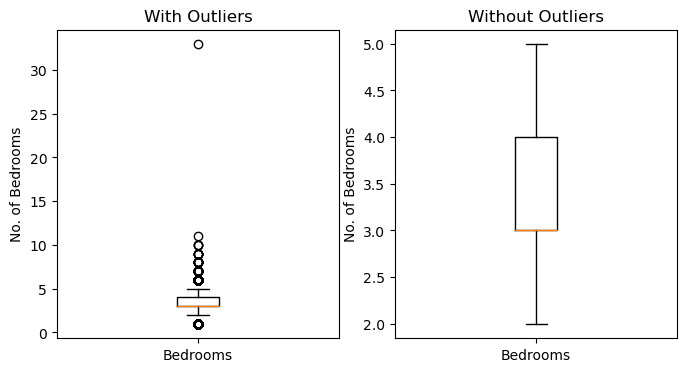

In [15]:
# generating boxplots for bedroom with and without outliers 
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].boxplot(kc.bedrooms)
axes[1].boxplot(kc.bedrooms, showfliers=False)

axes[0].title.set_text('With Outliers')
axes[1].title.set_text('Without Outliers')
axes[0].set_xlabel("Bedrooms")
axes[1].set_xlabel("Bedrooms")
axes[0].set_ylabel("No. of Bedrooms")
axes[1].set_ylabel("No. of Bedrooms")
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[1].xaxis.set_tick_params(labelbottom=False);

From the boxplots above, we can see a few outliers with more than five bedrooms. Taking into consideration that the majority of King County Real Estate Agency's clientele would be selling single-family homes, I decided to remove the outliers that would not be relevant to our analysis and would potentially skew our model.

In [16]:
# removing houses with more than five bedrooms 
kc = kc[kc.bedrooms < 6]

Taking a look at the distribution of bathrooms also reveals a few outliers, which I have also decided to remove.

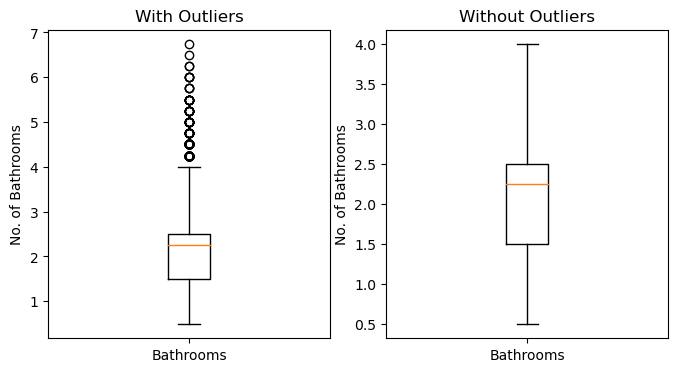

In [17]:
# generating boxplots for bathrooms with and without outliers 
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].boxplot(kc.bathrooms)
axes[1].boxplot(kc.bathrooms, showfliers=False)

axes[0].title.set_text('With Outliers')
axes[1].title.set_text('Without Outliers')
axes[0].set_xlabel("Bathrooms")
axes[1].set_xlabel("Bathrooms")
axes[0].set_ylabel("No. of Bathrooms")
axes[1].set_ylabel("No. of Bathrooms")
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[1].xaxis.set_tick_params(labelbottom=False);

In [18]:
# removing houses with more than four bathrooms 
kc = kc[kc.bedrooms < 5]

The final dataset I will be using includes the following variables:

* Number of bedrooms
* Number of bathrooms
* Square footage of total finished living space (including finished space in a basement)
* Square footage of the lot
* Floors
* Whether the house has a view to a waterfront
* Condition
* Grade
* Square footage of the living (excluding the basement)
* Latitude
* Longitude
* Month sold
* Age
* Distance to Seattle (in km)
* Distance to Bellevue (in km)

Further column descriptions were taken from King County's Residential Glossary of Terms (https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r).

In [19]:
kc.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,lat,long,month_sold,age,dist_seattle,dist_bellevue
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,47.5112,-122.257,10,59,11.994583,11.762420
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,47.7210,-122.319,12,63,12.816995,15.162997
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,47.7379,-122.233,2,82,16.459384,14.404860
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,47.5208,-122.393,12,49,10.510256,17.499539
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,47.6168,-122.045,2,28,21.670615,11.789400


#### 1.5. Train Test Split

To avoid data leakage, I split the dataset into a train and test set. 

In [20]:
X = kc.drop('price', axis=1)
y = kc['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [21]:
X_train.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,lat,long,month_sold,age,dist_seattle,dist_bellevue
count,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00
mean,3.19,2.05,1979.58,14936.29,1.48,0.01,3.41,7.60,1723.76,47.56,-122.21,6.58,43.25,18.68,17.57
std,0.70,0.71,825.14,42015.01,0.54,0.08,0.65,1.13,767.46,0.14,0.14,3.11,29.30,10.80,9.12
min,1.00,0.50,370.00,520.00,1.00,0.00,1.00,3.00,370.00,47.16,-122.52,1.00,-1.00,1.44,0.26
25%,3.00,1.50,1380.00,5000.00,1.00,0.00,3.00,7.00,1170.00,47.46,-122.33,4.00,18.00,9.82,11.63
50%,3.00,2.00,1830.00,7500.00,1.00,0.00,3.00,7.00,1520.00,47.57,-122.23,6.00,39.00,16.73,15.38
75%,4.00,2.50,2420.00,10400.00,2.00,0.00,4.00,8.00,2120.00,47.68,-122.12,9.00,63.00,25.64,21.77
max,4.00,5.75,7850.00,1651359.00,3.50,1.00,5.00,13.00,7850.00,47.78,-121.31,12.00,115.00,77.37,67.56


### 2. Understanding the Training Data
#### 2.1. Identifying Categorical Variables

From our descriptive statistics using `.describe()`, we can see that bedrooms, bathrooms, floors, waterfront, condition, grade, and month_sold have values with a limited range, which suggests that they represent categorical variables. 

To confirm which columns represent categorical variables, I used scatter plots to identify which variables generated vertical lines (signifying discrete values). So that I can plot the predictors as a function of price, I have used the original dataset `kc`.

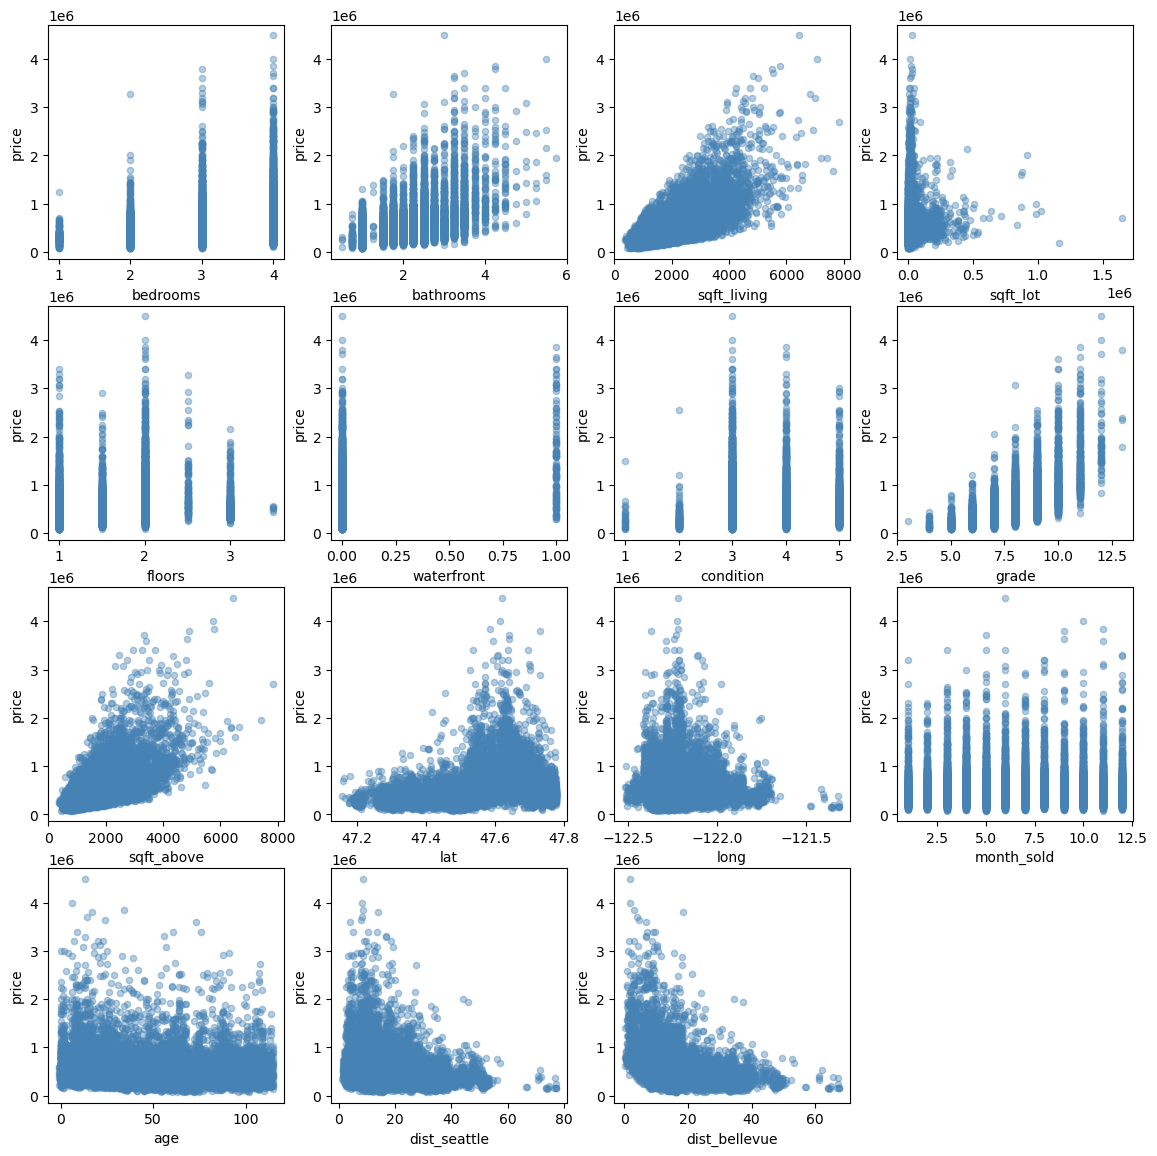

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14,14))

# delete empty subplots
fig.delaxes(axes[3,3])

predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'lat', 
              'long', 'month_sold', 'age', 'dist_seattle', 'dist_bellevue']

for xcol, ax in zip(predictors, axes.flatten()): 
    kc.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='steelblue');

From the scatter plots above, we can confirm that the variables previously identified clearly represent categorical variables.

We can also see that the majority of continuous variables appear to have a linear relationship with price, with the exceptions of `sqft_lot` and `age`. I decided to explore these two variables more in my `X_train` data.

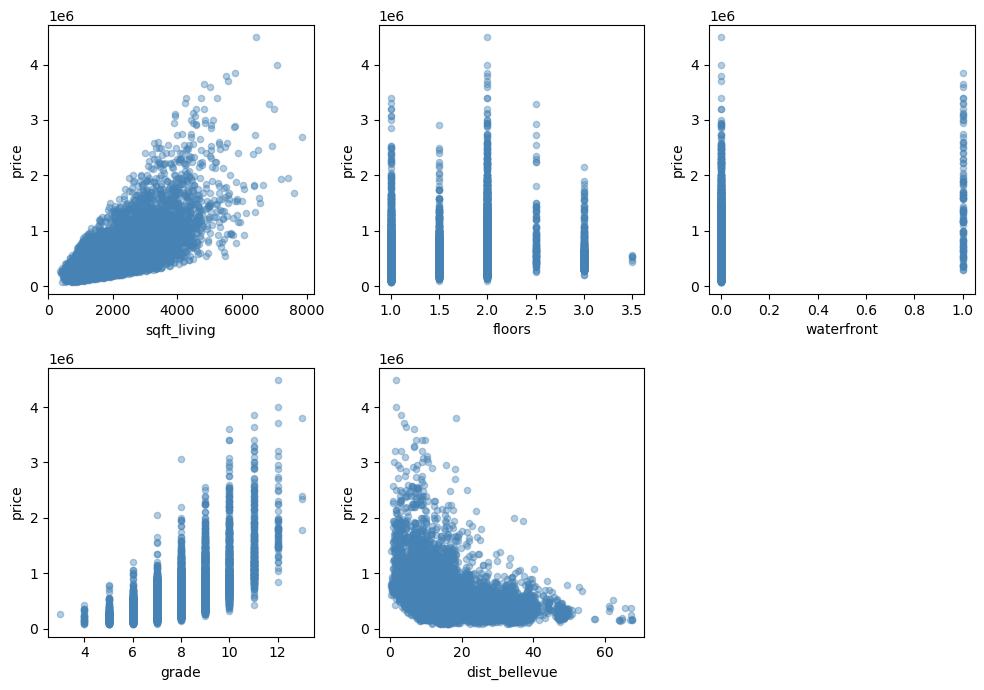

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7))

# delete empty subplots
fig.delaxes(axes[1,2])

predictors = ['sqft_living', 'floors', 'waterfront', 'grade', 'dist_bellevue']

for xcol, ax in zip(predictors, axes.flatten()): 
    kc.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='steelblue')

plt.tight_layout()
plt.savefig('./images/predictors_2.png');

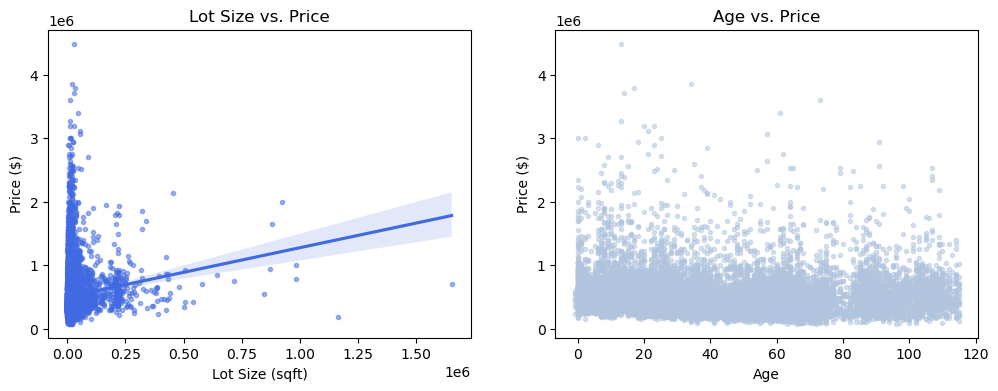

In [23]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.regplot(x=X_train.grade, y=y_train, color='royalblue', scatter_kws={'alpha':0.5, 's':9}, ax=axes[0]).set(title='Lot Size vs. Price')
axes[0].set_xlabel('Lot Size (sqft)')
axes[1].set_xlabel('Age')
axes[0].set_ylabel('Price ($)')
axes[1].set_ylabel('Price ($)');

Age clearly does not have a linear relationship with price, and while lot size does yield a line of regression there is a lot of noise and variability skewing results particularly towards as lot size decreases. For now, I will only be dropping `age`.

In [24]:
# dropping age
X_train.drop(['age'], axis=1, inplace=True)

#### 2.2. Account for Multicollinearity

In [25]:
# creating a correlation matrix
X_train.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,lat,long,month_sold,dist_seattle,dist_bellevue
bedrooms,1.000000,0.487121,0.563200,0.039755,0.199476,-0.013318,0.025103,0.381795,0.499843,-0.051619,0.181666,0.005941,0.137903,0.008231
bathrooms,0.487121,1.000000,0.723315,0.085119,0.518734,0.045119,-0.123543,0.656356,0.660479,0.008823,0.239548,0.012029,0.117329,-0.026208
sqft_living,0.563200,0.723315,1.000000,0.178890,0.343556,0.092096,-0.057868,0.758214,0.874729,0.038549,0.257069,0.019909,0.109732,-0.069389
sqft_lot,0.039755,0.085119,0.178890,1.000000,-0.009558,0.014407,-0.014335,0.120688,0.187030,-0.092475,0.225587,-0.007833,0.243987,0.182743
floors,0.199476,0.518734,0.343556,-0.009558,1.000000,0.015209,-0.270695,0.451213,0.507203,0.047574,0.123201,0.015324,0.004991,-0.032552
waterfront,-0.013318,0.045119,0.092096,0.014407,0.015209,1.000000,0.018428,0.071543,0.057255,-0.017549,-0.043776,0.010056,-0.012342,-0.002747
condition,0.025103,-0.123543,-0.057868,-0.014335,-0.270695,0.018428,1.000000,-0.148838,-0.157124,-0.009033,-0.100956,0.015861,-0.068357,-0.042394
grade,0.381795,0.656356,0.758214,0.120688,0.451213,0.071543,-0.148838,1.000000,0.749788,0.114534,0.200841,0.018413,0.017102,-0.146744
sqft_above,0.499843,0.660479,0.874729,0.187030,0.507203,0.057255,-0.157124,0.749788,1.000000,-0.015783,0.360330,0.017715,0.222541,0.009528
lat,-0.051619,0.008823,0.038549,-0.092475,0.047574,-0.017549,-0.009033,0.114534,-0.015783,1.000000,-0.140101,0.021854,-0.598016,-0.684702


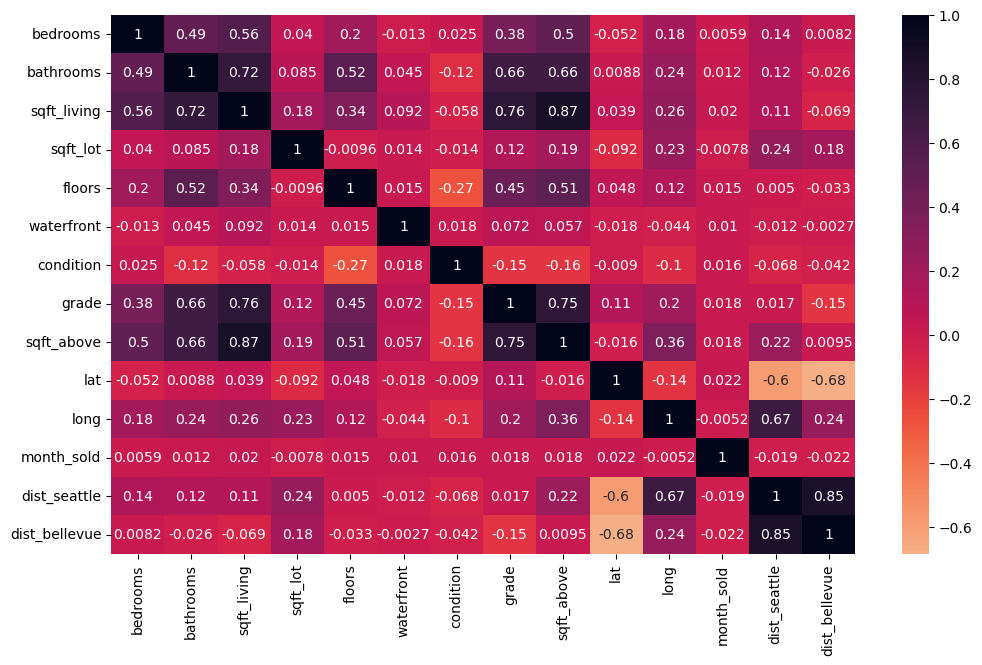

In [26]:
# visualising correlations
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(X_train.corr(), center=0, annot=True, cmap='rocket_r');

In [27]:
# saving absolute value of the correlation matrix as a data frame
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))
df.drop(columns=['level_1','level_0'], inplace=True)
df.set_index(['pairs'], inplace=True)
df.columns = ['cc']

In [28]:
df[(df.cc >.75) & (df.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.874729
"(sqft_living, sqft_above)",0.874729
"(dist_bellevue, dist_seattle)",0.850119
"(dist_seattle, dist_bellevue)",0.850119
"(sqft_living, grade)",0.758214
"(grade, sqft_living)",0.758214


We can see that `sqft_living` is highly correlated with `sqft_above` and `grade`, however I decided to drop `sqft_above` as `sqft_living` shows a stronger linear relationship with price (as seen in the scatterplots earlier). `sqft_living` also represents the total finished living space, including finished space in a basement which would be displayed on the listing, whereas `sqft_above` only refers to the living area in a house excluding the basement. The correlation between `sqft_living` and `grade` is only just above 0.75 so I decided to keep both predictors.

I also chose to drop `dist_seattle` over `dist_bellevue` as the houses with a higher sale price were closer to Bellevue.

In [29]:
# dropping sqft_living and dist_seattle
X_train.drop(['sqft_above', 'dist_seattle'], axis=1, inplace=True)

## Data Modeling
### 1. Preparing for Model 1
#### 1.1. Creating Dummy Variables

In [30]:
def create_dummy(cat, df):
    '''
    Function takes a categorical Series and a dataframe and returns dummy variables using get_dummies(). 
    Note that no columns are dropped.
    '''
    return pd.get_dummies(df[f'{cat}'], prefix=f'{cat}', dtype=float)

Rather than dropping the first column of the dummy variables for `condition` and `grade`, I decided to drop the column containing the average value. 

For `condition`, this was 3: Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

For `grade`, this was 7: Average grade of construction and design. Commonly seen in plats and older sub-divisions.

This means that my model used the most logical baseline as reference points and yielded the most intuitive coefficients.

Baseline for my categorical variables:
* Bedrooms = 1
* Bathrooms = 0.5
* Floors = 1
* Waterfront = 0
* Condition = 3
* Grade = 7
* Month Sold = 1 (January)

In [31]:
# creating dummy variables
room_dummies = create_dummy('bedrooms', X_train)
bath_dummies = create_dummy('bathrooms', X_train)
flr_dummies = create_dummy('floors', X_train)
water_dummies = create_dummy('waterfront', X_train)
cond_dummies = create_dummy('condition', X_train)
grade_dummies = create_dummy('grade', X_train)
month_dummies = create_dummy('month_sold', X_train)

# removing original columns from dataset
X_train_m1 = X_train.drop(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'month_sold'], 
                                    axis=1)

# concating dummy columns into dataset
X_train_m1 = pd.concat([X_train_m1, room_dummies, bath_dummies, flr_dummies, water_dummies, cond_dummies, grade_dummies, month_dummies], 
                       axis=1)

# removing dropping one column for each categorical
X_train_m1.drop(['bedrooms_1', 'bathrooms_0.5', 'floors_1.0', 'waterfront_0.0', 'condition_3', 'grade_7', 'month_sold_1'], axis=1,
                          inplace=True)

X_train_m1.head()

,sqft_living,sqft_lot,lat,long,dist_bellevue,bedrooms_2,bedrooms_3,bedrooms_4,bathrooms_0.75,bathrooms_1.0,...,month_sold_3,month_sold_4,month_sold_5,month_sold_6,month_sold_7,month_sold_8,month_sold_9,month_sold_10,month_sold_11,month_sold_12
11352,2180,9726,47.5359,-122.233,8.583395,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6693,1060,10464,47.7313,-122.229,13.632827,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17943,2480,9238,47.4701,-122.364,19.797775,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18524,2510,5200,47.5631,-122.366,13.431789,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18135,1940,3800,47.6842,-122.309,11.537345,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Model 1 (Baseline)

I started off by building a baseline model including all predictors.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     648.5
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:11:26   Log-Likelihood:            -1.9801e+05
No. Observations:               14746   AIC:                         3.961e+05
Df Residuals:                   14685   BIC:                         3.966e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.274e+07   1.51e+06    -15.

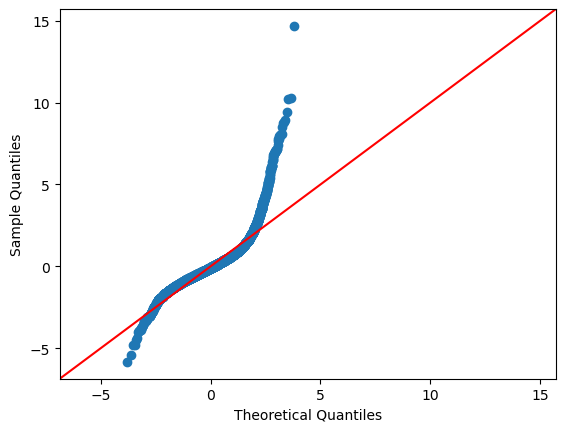

In [32]:
X = X_train_m1
y = y_train

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

### Model 1 Observations

While we can see that the r-squared for our first model is decent, at 0.726, the condition number is large indicating there is still strong multicollinearity or other numerical problems. Looking our residuals and kurtosis, we can also see that the normality assumption is violated.

I planned to address the following issues in my second iteration:

* Eliminate multicollinearity by bucketing appropriate categorical variables, to reduce the number of predictors
* * Log transforming appropriate continuous variables to normalise the data
* Increase interpretability of my model by scaling continuous features

I also decided to drop the following predictors: 
* `lat` and `long` as it does not provide geographical information relative to a specific point
* `bathrooms`, given that almost all variables did not yield significant p-values
* `month_sold`, given that half of the months did not yield significant p-values, with the exception of March and April

### 2. Preparing for Model 2

In [33]:
X_train.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,lat,long,month_sold,dist_bellevue
count,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00,14746.00
mean,3.19,2.05,1979.58,14936.29,1.48,0.01,3.41,7.60,47.56,-122.21,6.58,17.57
std,0.70,0.71,825.14,42015.01,0.54,0.08,0.65,1.13,0.14,0.14,3.11,9.12
min,1.00,0.50,370.00,520.00,1.00,0.00,1.00,3.00,47.16,-122.52,1.00,0.26
25%,3.00,1.50,1380.00,5000.00,1.00,0.00,3.00,7.00,47.46,-122.33,4.00,11.63
50%,3.00,2.00,1830.00,7500.00,1.00,0.00,3.00,7.00,47.57,-122.23,6.00,15.38
75%,4.00,2.50,2420.00,10400.00,2.00,0.00,4.00,8.00,47.68,-122.12,9.00,21.77
max,4.00,5.75,7850.00,1651359.00,3.50,1.00,5.00,13.00,47.78,-121.31,12.00,67.56


#### 2.1. Bucketing Categorical Variables

I decided to take a look at the `floor` value counts given the high p-value of floors 3.0 and 3.5.

In [34]:
X_train.floors.value_counts()

floors
1.0    7455
2.0    5505
1.5    1257
3.0     439
2.5      85
3.5       5
Name: count, dtype: int64

It looks as though houses with 3.5 floors are outliers and may be skewing results. I decided to combine these house with house with 3 floors into a new category, 3 or more floors (3+)

In [35]:
# combining houses with 3.5 floors with houses with 3 floors
X_train.floors = pd.cut(X_train.floors, bins=[0, 1, 1.5, 2, 2.5, np.inf], labels=['1', '1.5', '2', '2.5', '3+'])

/Users/rebeccachu/anaconda3/envs/learn-env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


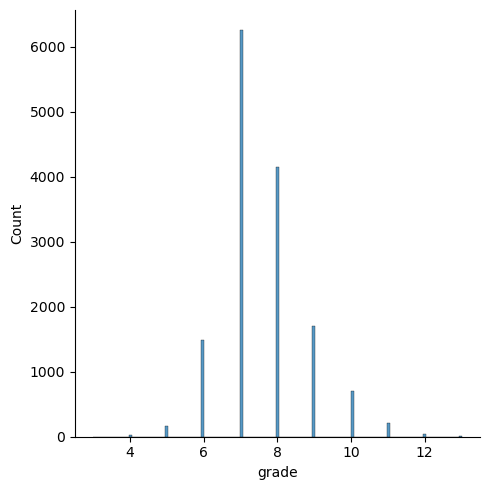

In [36]:
# checking the distribution of grade
sns.displot(X_train.grade);

Looking at the distribution of `grade` I also decided to group houses with a grade below 5 together into a new category.

In [37]:
X_train.grade = pd.cut(X_train.grade, bins=[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                       labels=['<5', '5', '6', '7', '8', '9', '10', '11', '12', '13'])

#### 2.2. Transforming Continuous Variables

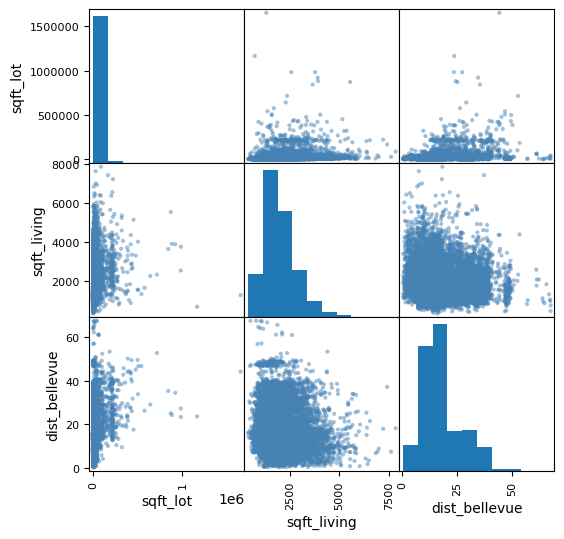

In [38]:
continuous = ['sqft_lot', 'sqft_living', 'dist_bellevue']

# checking the distribution of continuous data 
pd.plotting.scatter_matrix(X_train[continuous], figsize=(6,6), color='steelblue');

All continuous variables look positively skewed, so I decided to perform log transformations on each variable to normalise the data. I also standardised the continuous variables so that existed on the same scale. 

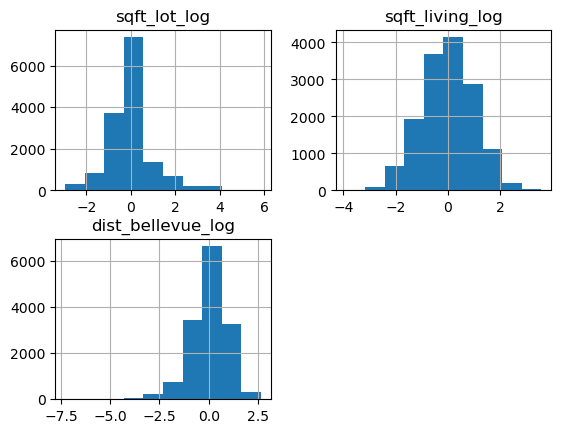

In [39]:
X_train_m2 = pd.DataFrame([])

# log transform continuous variables
X_train_m2['sqft_lot_log'] = np.log(X_train['sqft_lot'])
X_train_m2['sqft_living_log'] = np.log(X_train['sqft_living'])
X_train_m2['dist_bellevue_log'] = np.log(X_train['dist_bellevue'])

def normalize(feature):
    return (feature - feature.mean())/ feature.std()

cont_log = ['sqft_lot_log', 'sqft_living_log', 'dist_bellevue_log']

X_train_m2 = X_train_m2[cont_log].apply(normalize)

X_train_m2.hist();

#### 2.3. Creating Dummy Variables

In [40]:
# creating dummy variables
room_dummies = create_dummy('bedrooms', X_train)
flr_dummies = create_dummy('floors', X_train)
water_dummies = create_dummy('waterfront', X_train)
cond_dummies = create_dummy('condition', X_train)
grade_dummies = create_dummy('grade', X_train)

# concating dummy columns into dataset
X_train_m2 = pd.concat([X_train_m2, room_dummies, flr_dummies, water_dummies, cond_dummies, grade_dummies], axis=1)

# removing dropping one column for each categorical
X_train_m2.drop(['bedrooms_1', 'floors_1', 'waterfront_0.0', 'condition_3', 'grade_7'], axis=1, inplace=True)

X_train_m2.head()

,sqft_lot_log,sqft_living_log,dist_bellevue_log,bedrooms_2,bedrooms_3,bedrooms_4,floors_1.5,floors_2,floors_2.5,floors_3+,...,condition_5,grade_<5,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
11352,0.240479,0.438563,-1.031985,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6693,0.320589,-1.333613,-0.204400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17943,0.184093,0.755450,0.462977,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18524,-0.445361,0.785002,-0.230975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18135,-0.788922,0.151898,-0.502934,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model 2

Building the second model with the following predictors: sqft_lot_log, sqft_living_log, dist_bellevue_log, bedrooms, floors, waterfront, condition and grade. 

Continuous variables have been log transformed, including the target variable, and categorical variables have been grouped together as deemed approrpriate.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     1636.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:11:27   Log-Likelihood:                -1311.9
No. Observations:               14746   AIC:                             2674.
Df Residuals:                   14721   BIC:                             2864.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.0695      0.02

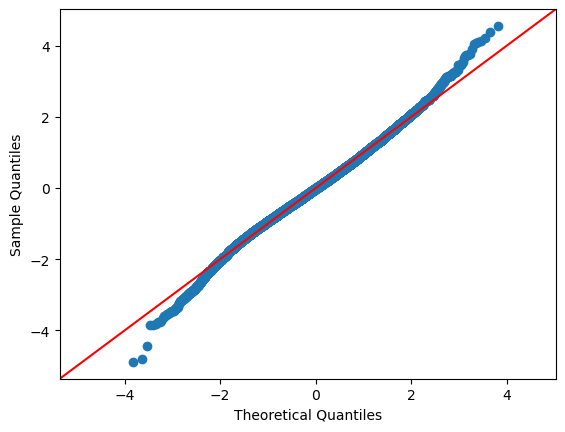

In [41]:
X = X_train_m2
y = np.log(y_train) # log transforming y 

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

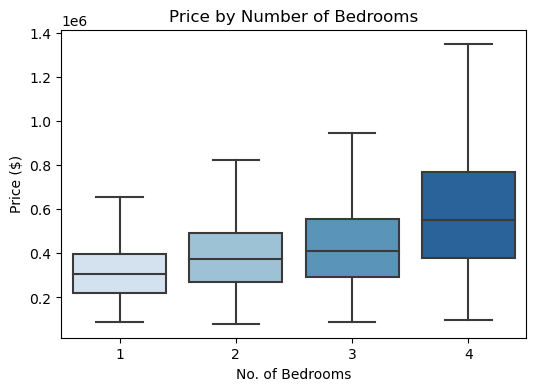

In [42]:
# plotting the relationship between the number of bedrooms and price
fig, axes = plt.subplots(figsize=(6,4))
sns.boxplot(x=X_train.bedrooms, y=y_train, palette='Blues', showfliers=False).set(title='Price by Number of Bedrooms')

plt.xlabel('No. of Bedrooms')
plt.ylabel('Price ($)');

### Model 2 Observations

In comparison to Model 1, we can see that residuals are now normalised and no longer violating the normality assumption. Skew, kurtosis and the condition number have also significantly dropped.

**Bedrooms**

Interstingly, all co-efficients of bedrooms were negative, suggesting that they had a negative linear relationship with price. Isolating the relationship between bedrooms and price however reveals a positive linear relationship (see above for the boxplot). There may be an interaction between bedroom size the number of bedrooms, which cannot be accounted for as we are missing this information. I therefore decided to drop `bedrooms` as a predictor variable for Model 3.

**Dropping Variables**

I also decided to drop `sqft_lot_log` as it had the weakest effect on price. 

`condition` was dropped in favour of `grade` as the latter had a greater impact on price. It would be recommended that houses have a condition of at least 3 (Average) or above, as price starts dropping when it has a condition of 1 (Poor-Worn) or 2 (Fair-Badly worn). 

**Floors**

Taking a look at the p-values, we can see that `floors_2` has a high p-value of 0.212 and a lower coefficient in comparison to other floors. I hypothesised that there may have interactions I hadn't explored.

In [43]:
linreg = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(linreg, X, y, scoring="r2", cv=crossvalidation))

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data["interaction"] = data[a] * data[b]
    score = np.mean(
        cross_val_score(linreg, data, y, scoring="r2", cv=crossvalidation)
    )
    if score > baseline:
        interactions.append((a, b, round(score, 3)))

    if i % 50 == 0:
        print(i)

print(
    "Top 5 interactions: %s"
    % sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5]
)

0
50
100
150
200
250
Top 5 interactions: [('sqft_lot_log', 'dist_bellevue_log', 0.729), ('sqft_living_log', 'floors_2', 0.728), ('bedrooms_2', 'floors_2', 0.728), ('sqft_lot_log', 'floors_2', 0.727), ('sqft_living_log', 'grade_6', 0.727)]


We can see that a few interactions involve `floors_2`, which would explain its high p-value and inconsistency in the context of other floors. As we would be dropping `bedrooms` and `sqft_lot_log` I decided to take a look at the interaction between `floors_2` and `sqft_living_log` only.

In [44]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final_m2 = X.copy()

final_m2['sqft_living_log*floors_2'] = (final_m2['sqft_living_log'] * final_m2['floors_2'])

final_model_2 = np.mean(cross_val_score(linreg, final_m2, y, scoring="r2", cv=crossvalidation))

print(f'Baseline r2: {baseline}')
print(f'Final Model r2: {final_model_2}')

Baseline r2: 0.7258573158735829
Final Model r2: 0.7275046530400922


We can see that accounting for the interaction between `sqft_living_log` and `floors_2` only increases the r2 score slightly, so we will also see if the interaction is significant.

In [79]:
X_train_m2.head()

,sqft_lot_log,sqft_living_log,dist_bellevue_log,bedrooms_2,bedrooms_3,bedrooms_4,floors_1.5,floors_2,floors_2.5,floors_3+,...,condition_5,grade_<5,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
11352,0.240479,0.438563,-1.031985,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6693,0.320589,-1.333613,-0.204400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17943,0.184093,0.755450,0.462977,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18524,-0.445361,0.785002,-0.230975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18135,-0.788922,0.151898,-0.502934,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
X_train_m2['price'] = y

In [84]:
X_train_m2.head()

,sqft_lot_log,sqft_living_log,dist_bellevue_log,bedrooms_2,bedrooms_3,bedrooms_4,floors_1.5,floors_2,floors_2.5,floors_3+,...,grade_<5,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,price
11352,0.240479,0.438563,-1.031985,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.681979
6693,0.320589,-1.333613,-0.204400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.623137
17943,0.184093,0.755450,0.462977,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.028053
18524,-0.445361,0.785002,-0.230975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.239257
18135,-0.788922,0.151898,-0.502934,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.348702


/Users/rebeccachu/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/rebeccachu/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


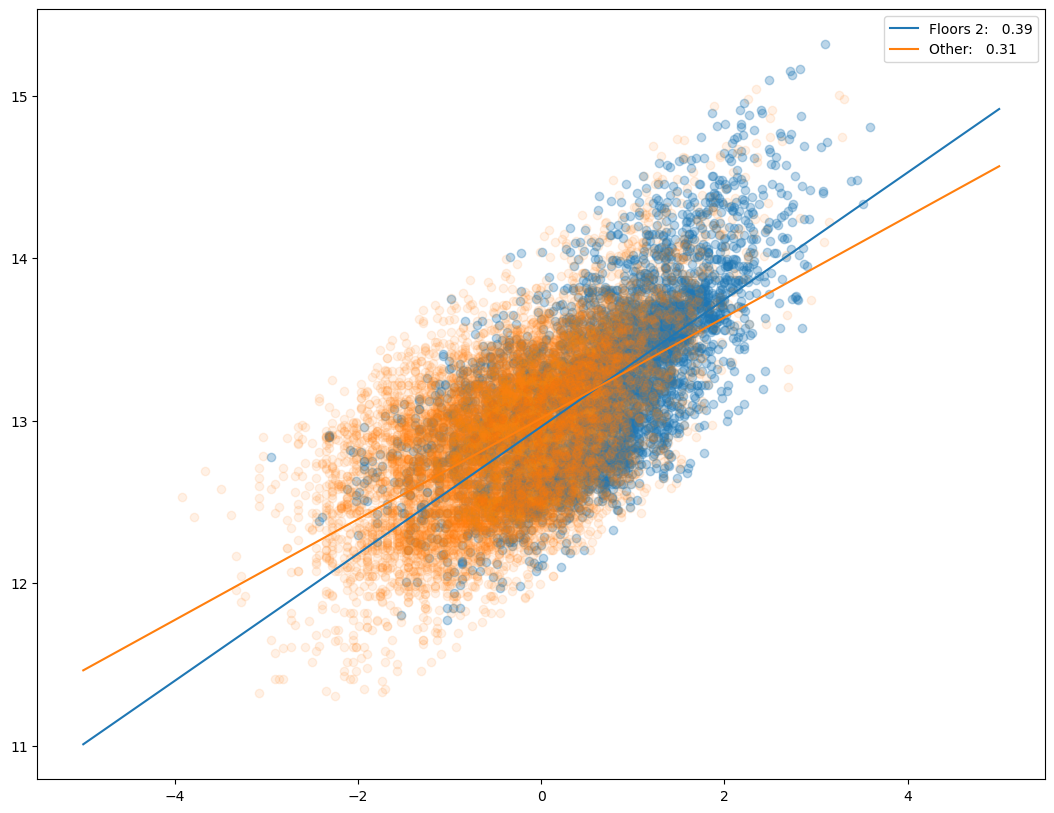

In [89]:
fig, ax = plt.subplots(figsize=(13, 10))

col = 'sqft_living_log'

is_in = X_train_m2.loc[
    X_train_m2['floors_2'] == 1, [col, 'price']
]

linreg.fit(is_in[[col]], is_in['price'])

preds = linreg.predict(is_in[[col]])

ax.scatter(is_in[[col]], is_in['price'], alpha=0.3, label=None)

x = np.linspace(-5, 5)
ax.plot(
    x, linreg.predict(x.reshape(-1, 1)), label=f"Floors 2:   {linreg.coef_[0]:.2f}"
)

not_in = X_train_m2.loc[
    X_train_m2['floors_2'] == 0, [col, 'price']
]

linreg.fit(not_in[[col]], not_in['price'])

preds = linreg.predict(not_in[[col]])

ax.scatter(not_in[[col]], not_in['price'], alpha=0.1, label=None)

x = np.linspace(-5, 5)
ax.plot(
    x,
    linreg.predict(x.reshape(-1, 1)),
    label=f"Other:   {linreg.coef_[0]:.2f}",
)

ax.legend()

In [45]:
X_int = sm.add_constant(final_m2)
model = sm.OLS(y, X_int).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     1584.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:11:57   Log-Likelihood:                -1267.2
No. Observations:               14746   AIC:                             2586.
Df Residuals:                   14720   BIC:                             2784.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       13.0558      0.023    555.580      0.000      13.010      13.102
sqft_lot_log                 0.0138      0.003      5.016      0.000       0.008       0.019
sqft_living_log              0.1924      0.004     44.006      0.000       0.184       0.201
dist_bellevue_log           -0.2114      0.002    -90.102      0.000      -0.216      -0.207
bedrooms_2                  -0.0630      0.023     -2.750      0.006      -0.108      -0.018
bedrooms_3                  -0.1884      0.023     -8.191      0.000      -0.233      -0.143
bedrooms_4                  -0.2231      0.024     -9.426      0.000      -0.270      -0.177
floors_1.5                   0.1486      0.008     18.096      0.000       0.132       0.165
floors_2                    -0.0066      0.006     -1.060      0.289      -0.019       0.006
floors_2.5                   0.1709      0.029      5.825      0.000       0.113       0.228
floors_3+                    0.1011      0.014      7.000      0.000       0.073       0.129
waterfront_1.0               0.6163      0.029     21.461      0.000       0.560       0.673
condition_1                 -0.1225      0.060     -2.054      0.040      -0.239      -0.006
condition_2                 -0.1562      0.024     -6.450      0.000      -0.204      -0.109
condition_4                  0.0461      0.005      8.630      0.000       0.036       0.057
condition_5                  0.1420      0.009     16.554      0.000       0.125       0.159
grade_<5                    -0.2790      0.061     -4.598      0.000      -0.398      -0.160
grade_5                     -0.3187      0.022    -14.654      0.000      -0.361      -0.276
grade_6                     -0.1748      0.008    -20.738      0.000      -0.191      -0.158
grade_8                      0.1500      0.006     24.860      0.000       0.138       0.162
grade_9                      0.3072      0.009     33.753      0.000       0.289       0.325
grade_10                     0.4240      0.013     32.179      0.000       0.398       0.450
grade_11                     0.5533      0.021     26.409      0.000       0.512       0.594
grade_12                     0.7194      0.042     17.177      0.000       0.637       0.802
grade_13                     1.0665      0.133      8.041      0.000       0.807       1.326
sqft_living_log*floors_2     0.0557      0.006      9.463      0.000       0.044       0.067
==============================================================================
Omnibus:                      174.210   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.455
Skew:                           0.032   Prob(JB):                     2.85e-67
Kurtosis:                       3.703   Cond. No.                     

The interaction between `sqft_living_log` and `floors_2` is significant and while the coefficient is low, I decided to keep it in the model to offset the negative coefficient of `floors_2`. 

### Model 3 (Final)

Building the final model with the following predictors: sqft_living_log, dist_bellevue_log, floors, waterfront, and grade. The interaction between sqft_living_log and floors_2 has also been accounted for.

Continuous variables have been log transformed, including the target variable.

In [46]:
X_train_m3 = pd.DataFrame([])

# log transforming continuous variables
X_train_m3['sqft_living_log'] = np.log(X_train['sqft_living'])
X_train_m3['dist_bellevue_log'] = np.log(X_train['dist_bellevue'])

cont_log = ['sqft_living_log', 'dist_bellevue_log']

# standardising continuous variables
X_train_m3 = X_train_m3[cont_log].apply(normalize)

# creating dummy variables
flr_dummies = create_dummy('floors', X_train)
water_dummies = create_dummy('waterfront', X_train)
grade_dummies = create_dummy('grade', X_train)

# concating dummy columns into dataset
X_train_m3 = pd.concat([X_train_m3, flr_dummies, water_dummies, grade_dummies], axis=1)

# removing dropping one column for each categorical
X_train_m3.drop(['floors_1', 'waterfront_0.0', 'grade_7'], axis=1, inplace=True)

# adding sqft_living and floors_2 interaction
X_train_m3['sqft_living_log*floors_2'] = (X_train_m3['sqft_living_log'] * X_train_m3['floors_2'])

In [47]:
X = X_train_m3
y = np.log(y_train) # log transforming y 

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     2178.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:11:57   Log-Likelihood:                -1625.7
No. Observations:               14746   AIC:                             3287.
Df Residuals:                   14728   BIC:                             3424.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       12.9014      0.004   3146.710      0.000      12.893      12.909
sqft_living_log              0.1681      0.004     43.451      0.000       0.160       0.176
dist_bellevue_log           -0.2132      0.002    -92.701      0.000      -0.218      -0.209
floors_1.5                   0.1438      0.008     17.280      0.000       0.127       0.160
floors_2                    -0.0378      0.006     -6.513      0.000      -0.049      -0.026
floors_2.5                   0.1414      0.030      4.734      0.000       0.083       0.200
floors_3+                    0.0519      0.014      3.791      0.000       0.025       0.079
waterfront_1.0               0.6636      0.029     22.631      0.000       0.606       0.721
grade_<5                    -0.2222      0.061     -3.632      0.000      -0.342      -0.102
grade_5                     -0.2849      0.022    -13.006      0.000      -0.328      -0.242
grade_6                     -0.1541      0.009    -18.078      0.000      -0.171      -0.137
grade_8                      0.1563      0.006     25.454      0.000       0.144       0.168
grade_9                      0.3228      0.009     35.054      0.000       0.305       0.341
grade_10                     0.4531      0.013     34.139      0.000       0.427       0.479
grade_11                     0.5880      0.021     27.696      0.000       0.546       0.630
grade_12                     0.7732      0.043     18.116      0.000       0.690       0.857
grade_13                     1.1053      0.136      8.141      0.000       0.839       1.371
sqft_living_log*floors_2     0.0566      0.006      9.560      0.000       0.045       0.068
==============================================================================
Omnibus:                      164.899   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.522
Skew:                           0.056   Prob(JB):                     3.31e-61
Kurtosis:                       3.664   Cond. No.                         75.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

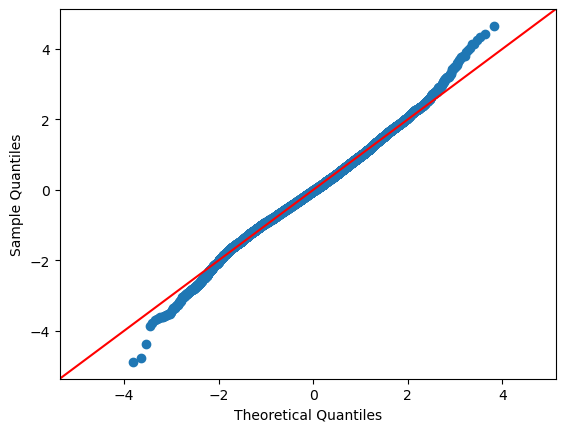

In [48]:
# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

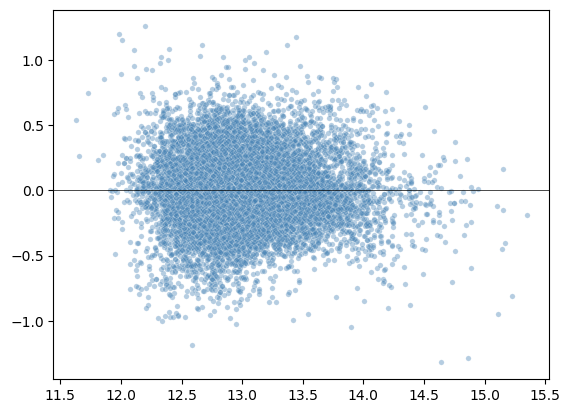

In [49]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

Visually, residuals appear to be homoscedastic however to confirm I performed the Goldfeld–Quandt test below:

In [50]:
name = ['F statistic', 'p-value']
test =  sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 1.0114175442484508), ('p-value', 0.31319397223462675)]

The p-value is greater than 0.05 so we fail to reject the null hypothesis and we do not have enough evidence to suggest that the homoscedasticity assumption is violated.

## Evaluation
### Model Validation

Validating the model against our test data to confirm that our model has not overfitted to our training data.

In [51]:
# transforming categories to match train data
X_test.grade = pd.cut(X_test.grade, bins=[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                       labels=['<5', '5', '6', '7', '8', '9', '10', '11', '12', '13'])

X_test.floors = pd.cut(X_test.floors, bins=[0, 1, 1.5, 2, 2.5, np.inf], labels=['1', '1.5', '2', '2.5', '3+'])

X_test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,lat,long,month_sold,age,dist_seattle,dist_bellevue
13365,4,2.75,2820,5000,1.5,0.0,3,8,2170,47.6376,-122.394,1,88,5.781785,14.789004
3667,3,2.00,2420,208652,1.5,0.0,3,8,2420,47.3666,-121.978,7,9,37.735825,31.884177
12404,3,2.25,2300,9914,2,0.0,4,8,2300,47.5677,-122.086,4,35,19.048695,9.884095
159,4,1.75,1760,11180,1,0.0,4,8,1760,47.4715,-122.118,10,46,22.033615,16.642647
8728,3,1.00,860,33664,1,0.0,4,6,860,47.2950,-122.275,9,59,34.861564,35.468472


In [52]:
# transforming test data
X_test_processed = pd.DataFrame([])

X_test_processed['sqft_living_log'] = np.log(X_test['sqft_living'])
X_test_processed['dist_bellevue_log'] = np.log(X_test['dist_bellevue'])

cont_log = ['sqft_living_log', 'dist_bellevue_log']

X_test_processed = X_test_processed[cont_log].apply(normalize)

flr_dummies = create_dummy('floors', X_test)
water_dummies = create_dummy('waterfront', X_test)
grade_dummies = create_dummy('grade', X_test)

X_test_processed = pd.concat([X_test_processed, flr_dummies, water_dummies, grade_dummies], axis=1)

X_test_processed.drop(['waterfront_0.0', 'floors_1', 'grade_7'], axis=1, inplace=True)

X_test_processed['sqft_living_log*floors_2'] = (X_test_processed['sqft_living_log'] * X_test_processed['floors_2'])

In [53]:
linreg.fit(X, y)

LinearRegression()

In [54]:
linreg.score(X, y)

0.7154573437989149

I used cross validation to confirm that the r2 score would be similar for different splits of the KC house data and that this specific was not split was not yielding over optimistic or pessimistic results.

In [64]:
X_org = kc.drop('price', axis=1)
y_org = kc.price

In [65]:
cross_val_score(linreg, X_org, y_org)

array([0.71982248, 0.71500083, 0.70595319, 0.70775359, 0.71626465])

In [56]:
X_test = X_test_processed
y_test = np.log(y_test)

linreg.score(X_test, y_test)

0.7273353103160416

In [57]:
y_hat_train = linreg.predict(X)
y_hat_test = linreg.predict(X_test_processed)

In [58]:
train_mse = mean_squared_error(y, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.0729939201707309
Test Mean Squared Error: 0.07133698771776129


The difference between the train MSE and the test MSE is minimal, indicating the we are not overfitting to our training data. I decided to take the average MSE using cross validation to ensure the difference between training and test MSE averages were also small. 

Train MSE Average: 28932092337.96596
Test MSE Average: 29092355111.84321


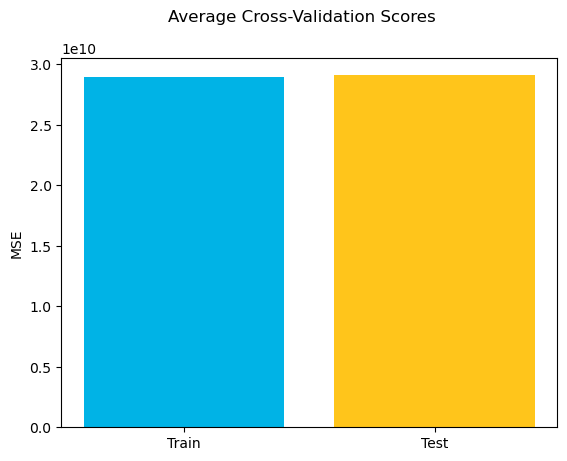

In [66]:
cross_val_results = cross_validate(linreg, X_org, y_org, scoring="neg_mean_squared_error", return_train_score=True)
# negative signs in front to convert back to MSE from -MSE
train_avg = -cross_val_results["train_score"].mean()
test_avg = -cross_val_results["test_score"].mean()

labels = ["Train", "Test"]
colors = ["#00B3E6", "#FFC51B"]

fig, ax = plt.subplots()
ax.bar(labels, [train_avg, test_avg], color=colors)
ax.set_ylabel("MSE")
fig.suptitle("Average Cross-Validation Scores");

print(f'Train MSE Average: {train_avg}')
print(f'Test MSE Average: {test_avg}')    

My third and final model yielded a r2 score of 0.715, taking into consideration 5 predictors and 1 interaction term: 
* the square footage of total living space,
* the distance from Bellevue,
* the number of floors,
* whether the house had a view to a waterfront,
* the construction quality of improvements (as grade from 1 to 13),
* and the interaction between total living space and houses with two floors.

This only slightly below my baseline model of 0.726.

The model therefore represents 71.5% of the variance of house sale prices for King County from May 2014 to May 2015 with the following coefficients:

In [60]:
model.params

const                       12.901368
sqft_living_log              0.168077
dist_bellevue_log           -0.213223
floors_1.5                   0.143770
floors_2                    -0.037811
floors_2.5                   0.141368
floors_3+                    0.051897
waterfront_1.0               0.663562
grade_<5                    -0.222200
grade_5                     -0.284872
grade_6                     -0.154125
grade_8                      0.156281
grade_9                      0.322796
grade_10                     0.453090
grade_11                     0.587976
grade_12                     0.773181
grade_13                     1.105327
sqft_living_log*floors_2     0.056608
dtype: float64

It is important to keep in mind that all continuous variables, including the target data, were log transformed. For example, regression formula should be interpeted as follows: 

* A 1% increase in `sqft_living_log` is associated with an average increase of 0.17% in price
* If the house has 2 floors, we would expect a -0.04% decrease in comparison to a house with 1 floor
* However, the price of a house with two floors will increase by 0.06% as the total living area increases 
* Houses with a waterfront view are associated with an 0.66% increase
* Houses with a grade below 5 would expected -0.22% decrease in price, in comparison to grade 7 houses

It is to be noted that this data only spans across one year, and may not generalise well to years beyond particularly considering inflation. Further data regarding housing prices since 2015 would be useful in building a more accurate model. Given that the model performed well across different splits of the training and testing data, I am confident that the variables chosen remain accurate predictors, however the coefficients would need to be revised to align with today's housing prices.

## Conclusions

This multiple linear regression analysis aimed to answer two key data questions: which features of a house are the best predictors for price, and what actionable insights can be recommended to a homeowner to increase the price of their property. 

From our model we found that **the total living area, building grade of the house, number of floors, waterfront views, and distance to Bellevue were the best predictors of sale price.** The building grade of the house had the strongest relationship with price; the higher quality of design, build and materials was associated with a larger increase in price. 

An increase in living space and floors was also generally associated with an increase in price, though not as great, and the further away the house was from Bellevue the more the price was expected to drop. 

As a homeowner, the following actionable insights can be taken to increase the price of their property: 
* **Increasing the size of their total living space.** Finished spaces in the basement are included in this variable, and may be an easy way to increase the living space without sacrificing free space in the lot if the basement was previously unfinished. We would recommend only adding a second floor to the house, houses with three storeys or more had a weaker effect on price in comparison to two storey houses; this could be due to less demand. To see whether expanding the living area via horizontal extensions would be profitable, further analysis should be done to examine whether sacrificing free lot space would result in an increase in price or have an inverse effect. 
* **Increasing the grade of their house.** Renovations with a higher quality finish, custom design and excellent craftsmanship are associated with a significant increase in price.

It should be noted that this model only predict house sale prices, not net profit; it is possible that renovations may not be worth completing if expenses outway profits.

**Limitations**

With the exception of the distance to Bellevue, this model focused solely on the features of the house and did not take into consideration houses' proximity to schools, shopping centres, hospitals, public transport and other amenities, all of which are external factors that may also determine the price of the home. It is also notes that the distance to Bellevue was measured via a straight-line distance, which may not be an accurate reflector of the distance or time it may take to travel into the city, although it does give an approximate guide. 